In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np
import os

In [2]:
password = os.getenv('NEO4J_Password')
neo4j_directory = os.getenv('NEO4J_Directory')

In [3]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [4]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

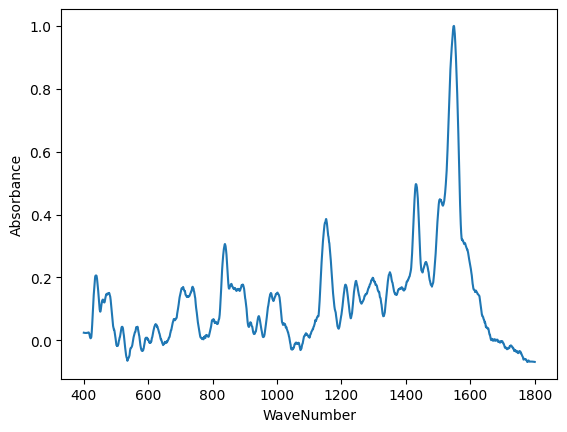

In [5]:
sample = df[df['SpecID'] == "210526-3-06"]
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

In [6]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,0.203556
1,201210-1-00,294,400.91116,201210-1,Normal,0.203010
2,201210-1-00,295,401.59454,201210-1,Normal,0.202464
3,201210-1-00,296,402.27789,201210-1,Normal,0.201917
4,201210-1-00,297,402.96127,201210-1,Normal,0.201370
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-0.078901
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-0.074710
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-0.070333
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-0.065772


In [7]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [8]:
pivot_df = prepare_wavelength_df(df, 'Absorbance')

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(pivot_df, test_size=0.2, random_state=1234)

In [10]:
test = test.reset_index()

In [11]:
test = test[['SpecID', 'Status']]

# Train

In [12]:
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = train.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

def gaussian_kernel(distances, sigma):
    return np.exp(-distances**2 / (2 * sigma**2))

# Sigma is the bandwidth parameter
sigma = 5 # Adjust sigma as needed
kernel_matrix = gaussian_kernel(distance_matrix, sigma)

# Convert the kernel matrix to a DataFrame
train_kernel_df = pd.DataFrame(kernel_matrix, index=train.index, columns=train.index)

# Full

In [13]:
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = pivot_df.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

In [14]:
def gaussian_kernel(distances, sigma):
    return np.exp(-distances**2 / (2 * sigma**2))

# Sigma is the bandwidth parameter
sigma = 5 # Adjust sigma as needed
kernel_matrix = gaussian_kernel(distance_matrix, sigma)

# Convert the kernel matrix to a DataFrame
kernel_df = pd.DataFrame(kernel_matrix, index=pivot_df.index, columns=pivot_df.index)

In [15]:
kernel_df

SpecID,201210-1-00,201210-1-01,201210-1-02,201210-1-03,201210-1-04,201210-1-05,201210-1-06,201210-1-07,201210-1-09,201210-1-10,...,210526-3-40,210526-3-41,210526-3-42,210526-3-43,210526-3-44,210526-3-45,210526-3-46,210526-3-47,210526-3-48,210526-3-49
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.574422,0.063503,0.044664,0.206733,0.126497,0.051962,0.067385,0.054115,0.054488,...,0.041752,0.056609,0.099148,0.026815,0.035461,0.022377,0.031398,0.022114,0.035369,0.029030
201210-1-01,0.574422,1.000000,0.045741,0.035671,0.252771,0.154414,0.069699,0.078755,0.064440,0.066604,...,0.035053,0.049045,0.075016,0.023060,0.029542,0.019699,0.028551,0.020052,0.031169,0.023567
201210-1-02,0.063503,0.045741,1.000000,0.170565,0.040574,0.054238,0.032195,0.044668,0.028216,0.006017,...,0.000952,0.002319,0.015236,0.000510,0.000698,0.000332,0.000638,0.000486,0.000690,0.000541
201210-1-03,0.044664,0.035671,0.170565,1.000000,0.024103,0.025905,0.022564,0.032918,0.026676,0.008031,...,0.001670,0.003649,0.011799,0.000949,0.001296,0.000674,0.001203,0.001416,0.001555,0.001027
201210-1-04,0.206733,0.252771,0.040574,0.024103,1.000000,0.732906,0.292029,0.265936,0.206732,0.201553,...,0.047845,0.075050,0.121637,0.033497,0.039157,0.027647,0.042698,0.026861,0.038845,0.035823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,0.022377,0.019699,0.000332,0.000674,0.027647,0.012848,0.007398,0.007308,0.005323,0.014700,...,0.807861,0.723347,0.372059,0.839456,0.840326,1.000000,0.850750,0.737341,0.809173,0.679143
210526-3-46,0.031398,0.028551,0.000638,0.001203,0.042698,0.021051,0.012394,0.012642,0.009397,0.024130,...,0.806412,0.789388,0.421704,0.858157,0.835411,0.850750,1.000000,0.758053,0.832841,0.745905
210526-3-47,0.022114,0.020052,0.000486,0.001416,0.026861,0.012945,0.008333,0.008298,0.006324,0.014760,...,0.693662,0.642153,0.322564,0.741090,0.731494,0.737341,0.758053,1.000000,0.751016,0.625390


In [16]:
train_nodes_df = train['Status'].to_frame()
train_nodes_df = train_nodes_df.rename_axis("SpecID:ID")
train_nodes_df = train_nodes_df.rename(columns={"Status": ":LABEL"})

In [17]:
train_nodes_df.to_csv(f"{neo4j_directory}/import/nodes.csv")

In [18]:
train_relationship_df = train_kernel_df.reset_index()
train_relationship_df = train_relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
train_relationship_df = train_relationship_df.rename(columns={'SpecID': ':START_ID'})
train_relationship_df[':TYPE'] = 'LINK'

In [19]:
train_relationship_df = train_relationship_df[train_relationship_df[":START_ID"] != train_relationship_df[":END_ID"]]
train_relationship_df = train_relationship_df[train_relationship_df[":START_ID"] < train_relationship_df[":END_ID"]]

In [20]:
train_relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv")

In [21]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [22]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
Neo4j version: 5.12.0
Importing the contents of these files into C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\data\databases\neo4j:
Nodes:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv

Relationships:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv


Available resources:
  Total machine memory: 31.86GiB
  Free machine memory: 17.32GiB
  Max heap memory : 910.5MiB
  Max worker threads: 8
  Configured max memory: 14.86GiB
  High parallel IO: true

Cypher type normalization is enabled (disable with --normalize-types=false):
  Property type of 'Weight' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv

Import starting 2024-03-23 21:08:06.756+0000
  Estimated number of nodes: 2.44 k
  Estimated numbe

Run and connect to the Neo4j Database

In [23]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at teh top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [24]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Define the graph algorithms.

In [25]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [26]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [27]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [28]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [29]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [30]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [31]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [32]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [33]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'Weight',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [34]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [35]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'Louvain'])

In [36]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['name'], how='left')

In [37]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,210310-2-33,1.726978,615.378610,0.038236,0.181508,2,949
1,210318-2-37,1.668667,589.200271,0.036613,0.180177,1,56
2,210318-2-33,1.654195,584.408461,0.036312,0.179930,2,949
3,210310-2-35,1.622519,575.466391,0.035756,0.179462,2,949
4,210310-1-31,1.622096,575.527047,0.035761,0.179462,2,949
...,...,...,...,...,...,...,...
2431,210519-2-01,0.333670,69.439599,0.004316,0.153564,1,56
2432,210414-3-07,0.323025,49.068612,0.003058,0.152538,3,283
2433,210324-1-17,0.315941,62.372229,0.003875,0.153203,2,949
2434,201210-1-03,0.308067,59.521576,0.003698,0.153056,2,949


In [38]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,210211-2-15,-0.181587,-0.084300,0.165890,-0.065156,0.025445,0.243731,-0.228023,0.061306,0.081279,...,-0.046208,0.064869,-0.110818,0.264875,0.204218,-0.156120,-0.229121,-0.116926,-0.108697,-0.446110
1,210415-1-20,-0.025539,0.070573,0.304967,-0.055283,0.271490,0.185613,0.005728,-0.177539,-0.129520,...,-0.121457,0.123289,0.070456,-0.030550,0.127613,-0.050074,-0.066531,0.002761,-0.022542,-0.238707
2,210225-2-42,-0.136874,-0.026558,0.233999,-0.057776,0.122583,0.244238,-0.157940,-0.022778,-0.024570,...,-0.074848,0.096991,-0.053467,0.161552,0.185915,-0.137610,-0.189699,-0.080172,-0.092034,-0.401773
3,210311-2-11,-0.160153,-0.081032,0.230024,-0.025436,0.044822,0.281195,-0.166703,0.000044,0.004055,...,-0.054233,0.064232,-0.066164,0.237318,0.207672,-0.180613,-0.189913,-0.143831,-0.103633,-0.433357
4,210419-2-15,0.036103,0.051016,0.393902,-0.075703,0.307719,0.217554,0.012200,-0.263127,-0.060906,...,-0.043319,0.074329,0.112654,0.011163,0.052375,-0.111842,0.003538,-0.035062,0.089537,-0.243913


In [39]:
status_df = pd.read_csv(f"{neo4j_directory}/import/nodes.csv")

In [40]:
graph_df = pd.merge(df, status_df, left_on="SpecID", right_on="SpecID:ID", how="inner")
graph_df.drop(columns=["SpecID:ID"], inplace=True)

In [41]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID:ID", how="inner")
fast_graph_df.drop(columns=["SpecID:ID"], inplace=True)

In [42]:
graph_df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,:LABEL
0,210310-2-33,1.726978,615.378610,0.038236,0.181508,2,949,Normal
1,210318-2-37,1.668667,589.200271,0.036613,0.180177,1,56,Hypoglycemia
2,210318-2-33,1.654195,584.408461,0.036312,0.179930,2,949,Hypoglycemia
3,210310-2-35,1.622519,575.466391,0.035756,0.179462,2,949,Normal
4,210310-1-31,1.622096,575.527047,0.035761,0.179462,2,949,Normal
...,...,...,...,...,...,...,...,...
2431,210519-2-01,0.333670,69.439599,0.004316,0.153564,1,56,Hyperglycemia
2432,210414-3-07,0.323025,49.068612,0.003058,0.152538,3,283,Normal
2433,210324-1-17,0.315941,62.372229,0.003875,0.153203,2,949,Normal
2434,201210-1-03,0.308067,59.521576,0.003698,0.153056,2,949,Normal


In [43]:
graph_df.rename(columns={":LABEL":"Status"}, inplace=True)

In [44]:
fast_graph_df.rename(columns={":LABEL":"Status"}, inplace=True)

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = graph_df.drop(['SpecID', 'Status'], axis=1)
y = graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.4323 +/- 0.0210
ExtraTreesClassifier Cross-Validation Accuracy: 0.4241 +/- 0.0238


In [46]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
graph_rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
graph_rf_model.fit(X_train, y_train)

# Extra Trees model
graph_et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
graph_et_model.fit(X_train, y_train)

# Predictions
rf_predictions = graph_rf_model.predict(X_test)
et_predictions = graph_et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

In [47]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [48]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [49]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.45081967213114754


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.40      0.36      0.38       148
 Hypoglycemia       0.43      0.45      0.44       179
       Normal       0.51      0.54      0.53       161

     accuracy                           0.45       488
    macro avg       0.45      0.45      0.45       488
 weighted avg       0.45      0.45      0.45       488


Confusion Matrix:
[[53 63 32]
 [48 80 51]
 [33 41 87]]


In [50]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.4405737704918033


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.37      0.33      0.35       148
 Hypoglycemia       0.43      0.44      0.43       179
       Normal       0.51      0.55      0.53       161

     accuracy                           0.44       488
    macro avg       0.44      0.44      0.44       488
 weighted avg       0.44      0.44      0.44       488


Confusion Matrix:
[[49 64 35]
 [50 78 51]
 [34 39 88]]


In [51]:
get_feature_importances(graph_rf_model, X)

,Feature,Importance
0,PageRank,0.269603
2,EigenvectorCentrality,0.225095
3,ArticleRank,0.223619
1,DegreeCentrality,0.222803
4,Leiden,0.036661
5,Louvain,0.022220


In [52]:
get_feature_importances(graph_et_model, X)

,Feature,Importance
0,PageRank,0.260523
2,EigenvectorCentrality,0.233892
1,DegreeCentrality,0.232677
3,ArticleRank,0.229403
4,Leiden,0.026697
5,Louvain,0.016809


## FastRp

In [53]:
fast_graph_df

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,Status
0,210211-2-15,-0.181587,-0.084300,0.165890,-0.065156,0.025445,0.243731,-0.228023,0.061306,0.081279,...,0.064869,-0.110818,0.264875,0.204218,-0.156120,-0.229121,-0.116926,-0.108697,-0.446110,Hyperglycemia
1,210415-1-20,-0.025539,0.070573,0.304967,-0.055283,0.271490,0.185613,0.005728,-0.177539,-0.129520,...,0.123289,0.070456,-0.030550,0.127613,-0.050074,-0.066531,0.002761,-0.022542,-0.238707,Hypoglycemia
2,210225-2-42,-0.136874,-0.026558,0.233999,-0.057776,0.122583,0.244238,-0.157940,-0.022778,-0.024570,...,0.096991,-0.053467,0.161552,0.185915,-0.137610,-0.189699,-0.080172,-0.092034,-0.401773,Hypoglycemia
3,210311-2-11,-0.160153,-0.081032,0.230024,-0.025436,0.044822,0.281195,-0.166703,0.000044,0.004055,...,0.064232,-0.066164,0.237318,0.207672,-0.180613,-0.189913,-0.143831,-0.103633,-0.433357,Normal
4,210419-2-15,0.036103,0.051016,0.393902,-0.075703,0.307719,0.217554,0.012200,-0.263127,-0.060906,...,0.074329,0.112654,0.011163,0.052375,-0.111842,0.003538,-0.035062,0.089537,-0.243913,Hypoglycemia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,210415-2-42,-0.026721,0.070413,0.302784,-0.056548,0.271026,0.184631,0.004480,-0.176573,-0.127293,...,0.123715,0.068698,-0.029203,0.126691,-0.049767,-0.067539,0.003172,-0.022789,-0.238145,Hypoglycemia
2432,210224-1-15,-0.132622,-0.020414,0.238691,-0.060729,0.132647,0.243452,-0.152108,-0.029775,-0.026343,...,0.098791,-0.050690,0.157150,0.180695,-0.136762,-0.185417,-0.077166,-0.087570,-0.394686,Hypoglycemia
2433,210318-1-19,-0.191159,-0.047821,0.153175,-0.088277,0.045663,0.253688,-0.225097,0.057241,0.117304,...,0.054224,-0.122271,0.296990,0.184699,-0.168524,-0.225912,-0.134347,-0.108186,-0.423724,Hypoglycemia
2434,210225-1-24,-0.178490,-0.049567,0.172973,-0.075917,0.060357,0.247713,-0.219523,0.045108,0.074752,...,0.066348,-0.109175,0.268686,0.187547,-0.157135,-0.225575,-0.117145,-0.105511,-0.422369,Hypoglycemia


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X_train = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y_train= fast_graph_df['Status']

# Random Forest model
fastrp_rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
fastrp_rf_model.fit(X_train, y_train)

# Extra Trees model
fastrp_et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
fastrp_et_model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=1234)

In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np

et = ExtraTreesClassifier(random_state=1234)

# Performing 10-fold cross-validation for the classifier
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    et.fit(X_train, y_train)
    y_pred = et.predict(X_test)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    calculate_metrics(y_test, y_pred)

# Displaying the results
print(f'Accuracy: {np.mean(accuracy_scores):.4f} +/- {np.std(accuracy_scores):.4f}')
print(f'Precision: {np.mean(precision_scores):.4f} +/- {np.std(precision_scores):.4f}')
print(f'Recall: {np.mean(recall_scores):.4f} +/- {np.std(recall_scores):.4f}')
print(f'F1-Score: {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}')

Overall Accuracy: 0.4180327868852459


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.33      0.30      0.31        71
 Hypoglycemia       0.43      0.44      0.43        87
       Normal       0.47      0.50      0.49        86

     accuracy                           0.42       244
    macro avg       0.41      0.41      0.41       244
 weighted avg       0.41      0.42      0.42       244


Confusion Matrix:
[[21 27 23]
 [24 38 25]
 [19 24 43]]
Overall Accuracy: 0.4057377049180328


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.27      0.27      0.27        71
 Hypoglycemia       0.43      0.44      0.43        87
       Normal       0.50      0.49      0.49        86

     accuracy                           0.41       244
    macro avg       0.40      0.40      0.40       244
 weighted avg       0.41      0.41      0.41       244


Confusion Matrix:
[[19 27 25]
 [32 38 17]
 

Fast rp mixed with traditional graph metrics

In [56]:
joined_graph = pd.merge(graph_df, fast_graph_df, on=['SpecID', 'Status'], how='inner')

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = joined_graph.drop(columns=['SpecID', 'Status'])

# Target variable
y = joined_graph['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.6700819672131147
Extra Trees Accuracy: 0.6741803278688525


## Full Graph

In [83]:
nodes_df = pivot_df['Status'].to_frame()
nodes_df = nodes_df.rename_axis("SpecID:ID")
nodes_df = nodes_df.rename(columns={"Status": ":LABEL"})

In [85]:
nodes_df.to_csv(f"{neo4j_directory}/import/nodes.csv")

In [86]:
relationship_df = kernel_df.reset_index()
relationship_df = relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
relationship_df = relationship_df.rename(columns={'SpecID': ':START_ID'})
relationship_df[':TYPE'] = 'LINK'

In [87]:
relationship_df = relationship_df[relationship_df[":START_ID"] != relationship_df[":END_ID"]]
relationship_df = relationship_df[relationship_df[":START_ID"] < relationship_df[":END_ID"]]

In [88]:
relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv")

Then run the admin import command.

In [89]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
Neo4j version: 5.12.0
Importing the contents of these files into C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\data\databases\neo4j:
Nodes:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv

Relationships:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv


Available resources:
  Total machine memory: 31.86GiB
  Free machine memory: 16.71GiB
  Max heap memory : 910.5MiB
  Max worker threads: 8
  Configured max memory: 14.32GiB
  High parallel IO: true

Cypher type normalization is enabled (disable with --normalize-types=false):
  Property type of 'Weight' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv

Import starting 2024-03-23 21:16:57.971+0000
  Estimated number of nodes: 3.05 k
  Estimated numbe

Run and connect to the Neo4j Database

In [91]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#password = os.environ['NEO4J_Password']           # Neo4J password
password = '26622002'

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [92]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Define the graph algorithms.

Execute the algorithms and store the results in a Dataframe.

In [93]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [94]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'Louvain'])

In [95]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,-0.063157,0.151688,0.347843,0.083121,0.245962,0.029086,-0.168817,-0.087456,0.163411,...,-0.075012,0.129968,-0.066907,0.244233,0.241689,-0.154009,0.039699,-0.333163,-0.070629,-0.164790
1,201210-1-01,-0.058251,0.158791,0.329687,0.057200,0.222105,0.011957,-0.182352,-0.092280,0.170690,...,-0.063474,0.136352,-0.061442,0.252332,0.239394,-0.169403,0.056045,-0.357031,-0.085628,-0.149245
2,201210-1-02,-0.061107,0.192405,0.285248,0.001500,0.170423,0.004299,-0.237682,-0.092109,0.172177,...,-0.056183,0.163211,-0.012284,0.290624,0.172258,-0.199533,0.030425,-0.429215,-0.036538,-0.151338
3,201210-1-03,-0.058625,0.188092,0.295627,0.009686,0.177459,0.000200,-0.229312,-0.092460,0.176780,...,-0.050766,0.154808,-0.021857,0.292981,0.187486,-0.200475,0.041660,-0.424362,-0.051393,-0.149746
4,201210-1-04,-0.066362,0.155875,0.311509,0.029765,0.192997,-0.018237,-0.192543,-0.091272,0.177861,...,-0.052336,0.140102,-0.060428,0.264569,0.251973,-0.184977,0.070907,-0.383818,-0.102491,-0.132860


In [96]:
status_df = pd.read_csv(f"{neo4j_directory}/import/nodes.csv")
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID:ID", how="inner")
fast_graph_df.drop(columns=["SpecID:ID"], inplace=True)

In [97]:
fast_graph_df.rename(columns={":LABEL":"Status"}, inplace=True)

In [98]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['name'], how='left')
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,210310-2-33,1.727754,776.421010,0.034217,0.181794,66,735
1,210318-2-37,1.669597,743.347576,0.032762,0.180449,196,2294
2,210318-2-33,1.653402,736.489088,0.032458,0.180167,66,735
3,210310-2-35,1.624542,726.695344,0.032026,0.179755,66,2294
4,210310-1-31,1.621037,725.208238,0.031961,0.179690,66,735
...,...,...,...,...,...,...,...
3040,210414-3-07,0.319408,60.457838,0.002672,0.152501,68,51
3041,210324-1-17,0.318625,79.518642,0.003504,0.153267,66,735
3042,201210-1-03,0.306656,74.368252,0.003277,0.153054,66,735
3043,210217-2-39,0.302892,73.224539,0.003227,0.153004,66,735


In [99]:
df = pd.merge(df, status_df, left_on='SpecID', right_on='SpecID:ID', how='inner')
df.drop(columns=['SpecID:ID'], inplace=True)
df.rename(columns={':LABEL':'Status'}, inplace=True)

In [100]:
X_test = df.drop(['SpecID', 'Status'], axis=1)
y_test = df['Status']

# Predictions
rf_predictions = graph_rf_model.predict(X_test)
et_predictions = graph_et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

In [101]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.4059113300492611


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.31      0.36      0.33       915
 Hypoglycemia       0.42      0.62      0.50      1065
       Normal       0.57      0.23      0.33      1065

     accuracy                           0.41      3045
    macro avg       0.44      0.40      0.39      3045
 weighted avg       0.44      0.41      0.39      3045


Confusion Matrix:
[[325 517  73]
 [290 664 111]
 [426 392 247]]


In [102]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.3878489326765189


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.30      0.40      0.34       915
 Hypoglycemia       0.41      0.57      0.47      1065
       Normal       0.61      0.19      0.29      1065

     accuracy                           0.39      3045
    macro avg       0.44      0.39      0.37      3045
 weighted avg       0.45      0.39      0.37      3045


Confusion Matrix:
[[367 500  48]
 [373 607  85]
 [474 384 207]]


In [103]:
# Drop the SpecID column
X_test = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y_test = fast_graph_df['Status']

# Predictions
rf_predictions = fastrp_rf_model.predict(X_test)
et_predictions = fastrp_et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.3497536945812808
Extra Trees Accuracy: 0.3497536945812808


In [104]:
joined_graph = pd.merge(graph_df, fast_graph_df, on=['SpecID', 'Status'], how='inner')

In [105]:
joined_graph

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,Status,embedding_0,embedding_1,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,210310-2-33,1.726978,615.378610,0.038236,0.181508,2,949,Normal,-0.060997,0.168113,...,-0.046659,0.151073,-0.044939,0.281532,0.224308,-0.191597,0.064650,-0.405910,-0.088519,-0.145422
1,210318-2-37,1.668667,589.200271,0.036613,0.180177,1,56,Hypoglycemia,-0.061763,0.161303,...,-0.050947,0.145409,-0.053202,0.273014,0.240120,-0.186624,0.067515,-0.393028,-0.093759,-0.136328
2,210318-2-33,1.654195,584.408461,0.036312,0.179930,2,949,Hypoglycemia,-0.060652,0.173113,...,-0.049332,0.152914,-0.040501,0.281614,0.218985,-0.192308,0.059482,-0.408134,-0.081637,-0.147106
3,210310-2-35,1.622519,575.466391,0.035756,0.179462,2,949,Normal,-0.056702,0.166924,...,-0.044031,0.149614,-0.046812,0.278257,0.224989,-0.190151,0.066820,-0.402543,-0.094396,-0.139196
4,210310-1-31,1.622096,575.527047,0.035761,0.179462,2,949,Normal,-0.065638,0.167863,...,-0.048353,0.153972,-0.043364,0.281327,0.221472,-0.191993,0.063367,-0.408389,-0.086852,-0.155136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,210519-2-01,0.333670,69.439599,0.004316,0.153564,1,56,Hyperglycemia,-0.073737,0.132587,...,-0.064270,0.122348,-0.084080,0.248098,0.303440,-0.176206,0.087015,-0.354276,-0.114304,-0.088270
2432,210414-3-07,0.323025,49.068612,0.003058,0.152538,3,283,Normal,-0.052839,-0.007582,...,-0.121294,0.063312,-0.117712,0.110150,0.214394,0.062150,-0.070375,-0.034120,0.005452,-0.253529
2433,210324-1-17,0.315941,62.372229,0.003875,0.153203,2,949,Normal,-0.067469,0.189455,...,-0.057485,0.156594,-0.019842,0.288436,0.181063,-0.200772,0.037184,-0.427250,-0.042262,-0.148827
2434,201210-1-03,0.308067,59.521576,0.003698,0.153056,2,949,Normal,-0.058625,0.188092,...,-0.050766,0.154808,-0.021857,0.292981,0.187486,-0.200475,0.041660,-0.424362,-0.051393,-0.149746


In [106]:
# Drop the SpecID column
X_test = joined_graph.drop(columns=['SpecID', 'Status'])

# Target variable
y_test = joined_graph['Status']


# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.34893267651888343
Extra Trees Accuracy: 0.3526272577996716


Delete the projection

In [107]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [108]:
close_driver()